Data source: https://www.kaggle.com/puneet6060/intel-image-classification

In [1]:
!nvidia-smi

Mon Sep 18 06:11:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Install kaggle library
! pip install kaggle
# Create a directory
! mkdir ~/.kaggle
# Copy the json to there
! cp kaggle.json ~/.kaggle/
# Allocate the required permission
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Download the dataset
! kaggle datasets download puneet6060/intel-image-classification

 94% 324M/346M [00:01<00:00, 220MB/s]
100% 346M/346M [00:01<00:00, 204MB/s]


In [4]:
# Unzip the files
! unzip -qq /content/intel-image-classification.zip

In [5]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image
import time

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet152V2, ResNet50
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array

In [6]:
# Create new folder
os.makedirs('/content/scene')

In [7]:
# Move seg_train and seg_test into the same folder
for folder in os.listdir('/content/seg_train/seg_train'):
    shutil.move(os.path.join('/content/seg_train/seg_train', folder), '/content/scene')

for folder in os.listdir('/content/seg_test/seg_test'):
    for file_name in os.listdir(os.path.join('/content/seg_test/seg_test', folder)):
        shutil.move(os.path.join('/content/seg_test/seg_test', folder, file_name), os.path.join('/content/scene', folder))

In [8]:
# Create folders for training and validation datasets
os.makedirs('/content/training')
os.makedirs('/content/val')
os.makedirs('/content/testing')

classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
for a in classes:
    os.makedirs(os.path.join('/content/training', a))

for a in classes:
    os.makedirs(os.path.join('/content/val', a))

for a in classes:
    os.makedirs(os.path.join('/content/testing', a))

In [9]:
# Split the dataset into training (80%) and validation (20%) datasets randomly
n_data = len(os.listdir(os.path.join('/content/scene', folder)))
for folder in os.listdir('/content/scene'):
    random.seed(123)
    for file_name in random.sample(os.listdir(os.path.join('/content/scene', folder)), int(n_data*0.6125)):
        shutil.move(os.path.join('/content/scene', folder, file_name), os.path.join('/content/training', folder))

for folder in os.listdir('/content/scene'):
    random.seed(123)
    for file_name in random.sample(os.listdir(os.path.join('/content/scene', folder)), int(n_data*0.2)):
        shutil.move(os.path.join('/content/scene', folder, file_name), os.path.join('/content/testing', folder))

for folder in os.listdir('/content/scene'):
    for file_name in os.listdir(os.path.join('/content/scene', folder)):
        shutil.move(os.path.join('/content/scene', folder, file_name), os.path.join('/content/val', folder))

In [13]:
# Count the number of samples
classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
a = 0
for folder in classes:
  x = len(os.listdir(os.path.join('/content/training', folder)))
  a = a+x

b = 0
for folder in classes:
  x = len(os.listdir(os.path.join('/content/val', folder)))
  b = b+x

c = 0
for folder in classes:
  x = len(os.listdir(os.path.join('/content/testing', folder)))
  c = c+x
sum_all = a + b + c

print('The total number of dataset samples is ' + str(a+b))
print('The number of training samples is ' + str(a))
print('The number of validation samples is ' + str(b))
print('The number of testing samples is ' + str(c))
print(f'training: validation: testing = {round(a/sum_all,4)} : {round(b/sum_all,4)}: {round(c/sum_all,4)}')

The total number of dataset samples is 13698
The number of training samples is 10230
The number of validation samples is 3468
The number of testing samples is 3336
training: validation: testing = 0.6006 : 0.2036: 0.1958


In [14]:
# Create data generators
train_imgGen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

val_imgGen = ImageDataGenerator(rescale=1./255)

In [16]:
# Run the image generators
train_gen = train_imgGen.flow_from_directory(
        '/content/training',
        target_size=(150, 150),
        batch_size=4,
        class_mode='categorical')

val_gen = val_imgGen.flow_from_directory(
        '/content/val',
        target_size=(150, 150),
        batch_size=4,
        class_mode='categorical')

test_gen = val_imgGen.flow_from_directory(
        '/content/testing',
        target_size=(150, 150),
        batch_size=4,
        class_mode='categorical')

Found 10230 images belonging to 6 classes.
Found 3468 images belonging to 6 classes.
Found 3336 images belonging to 6 classes.


In [17]:
# Build CNN model
cnn = tf.keras.models.Sequential([
    ResNet152V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 150, 3))),
    tf.keras.layers.Conv2D(30, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='softmax')
])
cnn.layers[0].trainable = False

# Complie model CNN
opt = tf.keras.optimizers.Adam(learning_rate=1.0000e-03)
cnn.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

234545216/234545216 [==============================] - 1s 0us/step


In [18]:
start = time.time()
# Set callbacks
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=0, patience=10)

checkpoint = ModelCheckpoint(
    filepath='scene_classifier.hdf5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

tf.keras.utils.set_random_seed(123)

# Fit the CNN
cnn_history = cnn.fit(
      train_gen,
      epochs=30,
      batch_size=2000,
      validation_data=val_gen,
      callbacks=[es, checkpoint],
      verbose=2)

print('It took %s minutes' % ((time.time() - start)/60))

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2558/2558 - 152s - loss: 0.5580 - accuracy: 0.8206 - val_loss: 0.3887 - val_accuracy: 0.8821 - 152s/epoch - 59ms/step
Epoch 2/30
2558/2558 - 132s - loss: 0.3913 - accuracy: 0.8741 - val_loss: 0.3391 - val_accuracy: 0.8881 - 132s/epoch - 51ms/step
Epoch 3/30
2558/2558 - 138s - loss: 0.3413 - accuracy: 0.8890 - val_loss: 0.3776 - val_accuracy: 0.8821 - 138s/epoch - 54ms/step
Epoch 4/30
2558/2558 - 131s - loss: 0.3247 - accuracy: 0.8944 - val_loss: 0.3858 - val_accuracy: 0.8824 - 131s/epoch - 51ms/step
Epoch 5/30
2558/2558 - 137s - loss: 0.3131 - accuracy: 0.9023 - val_loss: 0.3296 - val_accuracy: 0.8948 - 137s/epoch - 53ms/step
Epoch 6/30
2558/2558 - 125s - loss: 0.2902 - accuracy: 0.9068 - val_loss: 0.4280 - val_accuracy: 0.8922 - 125s/epoch - 49ms/step
Epoch 7/30
2558/2558 - 130s - loss: 0.2947 - accuracy: 0.9100 - val_loss: 0.3230 - val_accuracy: 0.8953 - 130s/epoch - 51ms/step
Epoch 8/30
2558/2558 - 127s - loss: 0.2720 - accuracy: 0.9123 - val_loss: 0.4478 - val_accuracy: 0.8997 - 12

In [20]:
# evaluate model
_, acc = cnn.evaluate_generator(test_gen, steps=len(test_gen), verbose=0)
print('> %.3f' % (acc * 100.0))

<ipython-input-20-7551f8d18745>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, acc = cnn.evaluate_generator(test_gen, steps=len(test_gen), verbose=0)


> 90.558


In [21]:
import matplotlib.pyplot as plt

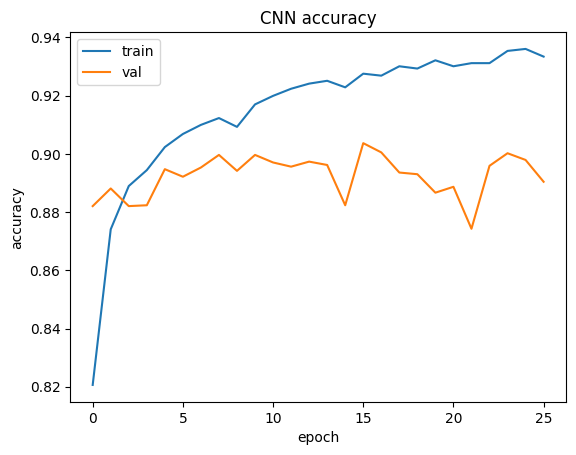

In [22]:
# Visualisasi history training CNN
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('CNN accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

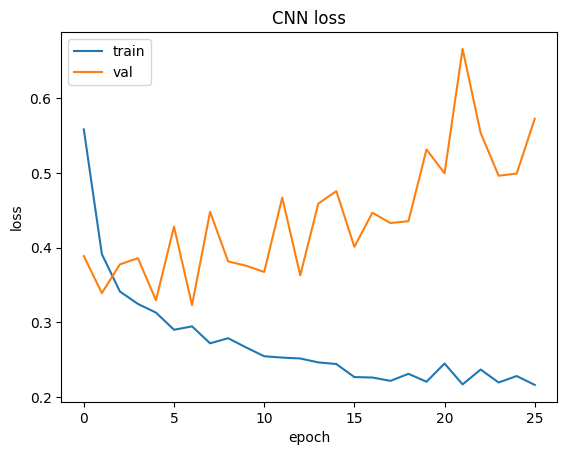

In [23]:
# Visualisasi history training CNN
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('CNN loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.image as mpimg
%matplotlib inline

In [36]:
def predict_image(path):
    img_up = image.load_img(path, target_size=(150,150))
    display = plt.imshow(img_up)
    arr = image.img_to_array(img_up)
    arr = arr.astype('float32') / 255.0
    arr = np.expand_dims(arr, axis=0)

    im_arr = np.vstack([arr])
    result = cnn.predict(im_arr, batch_size=10)
    result = result.tolist()
    result = result[0]

    print('filename: '+ f)
    print(result)
    print('')
    if result[0]==1:
      print('prediction: buildings')
    elif result[1]==1:
      print('prediction: forest')
    elif result[2]==1:
      print('prediction: glacier')
    elif result[3]==1:
      print('prediction: mountain')
    elif result[4]==1:
      print('prediction: sea')
    else:
      print('prediction: street')

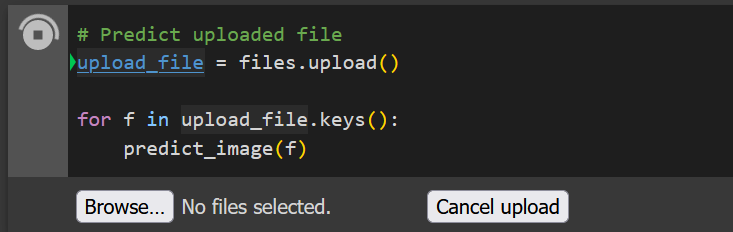

Saving 317.jpg to 317 (3).jpg
1/1 [==============================] - 0s 52ms/step
filename: 317 (3).jpg
[0.0, 1.0, 1.0959944076860468e-25, 0.0, 1.0486127074148539e-34, 0.0]

prediction: forest


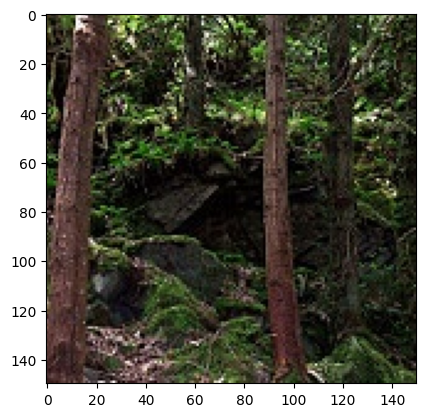

In [40]:
# Predict uploaded file
upload_file = files.upload()

for f in upload_file.keys():
    predict_image(f)

Saving 281.jpg to 281 (2).jpg
Saving 290.jpg to 290 (2).jpg
Saving 449.jpg to 449 (1).jpg
1/1 [==============================] - 0s 54ms/step
filename: 281 (2).jpg
[0.0, 0.0, 1.8139287596645386e-19, 1.5064493320605725e-23, 1.0, 0.0]

prediction: sea
1/1 [==============================] - 0s 55ms/step
filename: 290 (2).jpg
[9.683908797731684e-23, 8.010517028053128e-26, 2.522383857339605e-09, 1.2532366810980022e-10, 1.0, 2.7447669723609672e-24]

prediction: sea
1/1 [==============================] - 0s 51ms/step
filename: 449 (1).jpg
[0.0, 0.0, 3.200222243628974e-21, 1.5256945848499513e-25, 1.0, 0.0]

prediction: sea


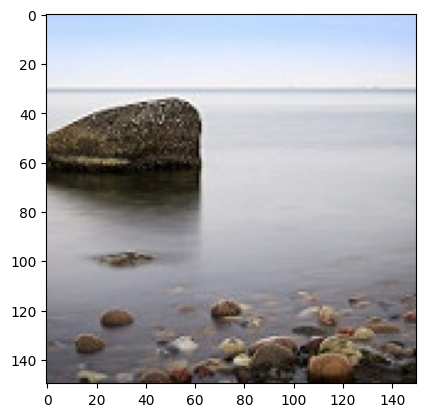

In [38]:
# Predict uploaded file
upload_file = files.upload()

for f in upload_file.keys():
    predict_image(f)

In [32]:
# Predict uploaded file
upload_file = files.upload()

for f in upload_file.keys():
    predict_image(f)

In [24]:
# Convert the model into the format of .tflite
tflite = tf.lite.TFLiteConverter.from_keras_model(cnn)
tflite_convert = tflite.convert()

with tf.io.gfile.GFile('cnn_scene.tflite', 'wb') as model:
  model.write(tflite_convert)

# Multiple prediction

In [35]:
from tqdm import tqdm

In [60]:
def predict_image_2(path):
    img = load_img(path, target_size=(150,150))
    img = img_to_array(img)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)

    result = cnn.predict(img, verbose=0)
    result = result.tolist()[0]
    return result

def multi_recognize_image(path):
    # List the image files
    file_name, true, pred, prob_1, prob_2, prob_3, prob_4, prob_5, prob_6 = [], [], [], [], [], [], [], [], []

    for folder in os.listdir(path):
        for file in tqdm(os.listdir(os.path.join(path, folder))):
            pred = predict_image_2(os.path.join(path, folder, file))

            file_name.append(file)
            true.append(folder)
            prob_1.append(pred[0])
            prob_2.append(pred[1])
            prob_3.append(pred[2])
            prob_4.append(pred[3])
            prob_5.append(pred[4])
            prob_6.append(pred[5])

    output = pd.DataFrame(
        {
            'file': file_name,
            'true': true,
            'pred': [0] * len(file_name),
            'buildings': prob_1,
            'forest': prob_2,
            'glacier': prob_3,
            'mountain': prob_4,
            'sea': prob_5,
            'street': prob_6,
        }
    )

    output['pred'] = output[
        ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
    ].idxmax(axis=1)

    return output

In [61]:
df_pred = multi_recognize_image('/content/testing/')

100%|██████████| 556/556 [01:00<00:00,  9.13it/s]


In [62]:
df_pred.head()

,file,true,pred,buildings,forest,glacier,mountain,sea,street
0,697.jpg,glacier,mountain,3.975282e-16,4.998172e-17,2.396634e-07,9.999996e-01,9.663719e-08,3.972261e-18
1,4370.jpg,glacier,mountain,1.156539e-02,2.310309e-02,1.419781e-01,6.348670e-01,1.812978e-01,7.188612e-03
2,23870.jpg,glacier,glacier,2.072904e-30,0.000000e+00,1.000000e+00,1.954120e-09,6.210417e-17,3.272576e-22
3,22557.jpg,glacier,glacier,2.577125e-06,7.770532e-06,7.172946e-01,2.766016e-01,6.068883e-03,2.451788e-05
4,22112.jpg,glacier,glacier,0.000000e+00,0.000000e+00,1.000000e+00,2.064655e-13,2.493125e-28,0.000000e+00


In [63]:
df_pred.to_csv('prediction_result.csv', index=False)

In [48]:
from sklearn.metrics import classification_report, confusion_matrix

In [64]:
label_list = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
print('confusion_matrix')
print(pd.DataFrame(
    confusion_matrix(df_pred['true'], df_pred['pred']),
    index=label_list,
    columns=label_list)
)
print('')
print('Classification Report')
print(classification_report(df_pred['true'], df_pred['pred']))

confusion_matrix
           buildings  forest  glacier  mountain  sea  street
buildings        510       2        1         0    7      36
forest             3     549        1         0    1       2
glacier            0       2      450        81   16       7
mountain           0       1       57       469   29       0
sea                5       0       16         4  529       2
street            33       0        0         0    9     514

Classification Report
              precision    recall  f1-score   support

   buildings       0.93      0.92      0.92       556
      forest       0.99      0.99      0.99       556
     glacier       0.86      0.81      0.83       556
    mountain       0.85      0.84      0.85       556
         sea       0.90      0.95      0.92       556
      street       0.92      0.92      0.92       556

    accuracy                           0.91      3336
   macro avg       0.91      0.91      0.91      3336
weighted avg       0.91      0.91      0.91  